In [1]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt

# Configuration
CONFIG = {
    "labeled_img": "dataset/labeled_data/images",
    "labeled_mask": "dataset/labeled_data/labels",
    "unlabeled_img": "dataset/unlabeled_data/images",
    "epochs": 50,
    "batch_size": 2,
    "lr": 1e-4,
    "num_classes": 3,
    "save_dir": "models",
    "num_workers": 2,
    "encoder": "efficientnet-b5",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Transforms
transform_labeled = T.Compose([
    T.Resize((384, 384)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(0.2, 0.2, 0.2, 0.1),
    T.ToTensor(),
])

transform_unlabeled = T.Compose([
    T.Resize((384, 384)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(0.3, 0.3, 0.3, 0.2),
    T.ToTensor(),
])

transform_mask = T.Compose([
    T.Resize((384, 384), interpolation=Image.NEAREST),
    T.PILToTensor(),
    lambda x: x.squeeze(0).long()
])

# Dataset
class CervicalDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) 
                            if f.endswith(('.png', '.jpg'))])
        if mask_dir:
            self.masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) 
                               if f.endswith(('.png', '.jpg'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        if self.mask_dir:
            mask = Image.open(self.masks[idx]).convert("L")
            return transform_labeled(image), transform_mask(mask)
        return transform_unlabeled(image)

# Semi-Supervised Model Wrapper
class SemiSupervisedModel(nn.Module):
    def __init__(self, num_classes=3, alpha=0.999):
        super().__init__()
        self.student = smp.DeepLabV3Plus(
            encoder_name=CONFIG['encoder'],
            encoder_weights='imagenet',
            in_channels=3,
            classes=num_classes,
            activation=None
        )
        self.teacher = smp.DeepLabV3Plus(
            encoder_name=CONFIG['encoder'],
            encoder_weights='imagenet',
            in_channels=3,
            classes=num_classes,
            activation=None
        )
        self._init_teacher()
        self.alpha = alpha
        
    def _init_teacher(self):
        with torch.no_grad():
            for t_param, s_param in zip(self.teacher.parameters(), self.student.parameters()):
                t_param.data.copy_(s_param.data)
                
    @torch.no_grad()
    def update_teacher(self, global_step):
        alpha = min(1 - 1/(global_step/100 + 1), self.alpha)
        for t_param, s_param in zip(self.teacher.parameters(), self.student.parameters()):
            t_param.data.mul_(alpha).add_(s_param.data, alpha=1-alpha)
            
    def forward(self, x):
        return self.student(x)

# Loss Functions
def compute_sat_loss(student_feats, teacher_feats, temperature=0.1):
    student_feats = F.normalize(student_feats, p=2, dim=1)
    teacher_feats = F.normalize(teacher_feats, p=2, dim=1)
    sim_matrix = torch.mm(student_feats, teacher_feats.t()) / temperature
    pos_sim = torch.diag(sim_matrix)
    neg_sim = (sim_matrix.sum(dim=1) - pos_sim) / (sim_matrix.size(1) - 1)
    loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim) + 1e-8)).mean()
    return loss

class CombinedLoss(nn.Module):
    def __init__(self, class_weights=None):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        
    def forward(self, preds, targets):
        ce = self.ce_loss(preds, targets)
        preds_soft = F.softmax(preds, dim=1)
        targets_oh = F.one_hot(targets, num_classes=CONFIG['num_classes']).permute(0,3,1,2).float()
        intersection = (preds_soft * targets_oh).sum(dim=(2,3))
        union = preds_soft.sum(dim=(2,3)) + targets_oh.sum(dim=(2,3))
        dice = 1 - (2 * intersection + 1e-6) / (union + 1e-6)
        return ce + dice.mean()

# Training Function
def train():
    device = torch.device(CONFIG['device'])
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    
    # Datasets
    labeled_ds = CervicalDataset(CONFIG['labeled_img'], CONFIG['labeled_mask'])
    unlabeled_ds = CervicalDataset(CONFIG['unlabeled_img'])
    
    # Class weights
    class_counts = torch.zeros(CONFIG['num_classes'])
    for _, mask in labeled_ds:
        class_counts += torch.bincount(mask.flatten(), minlength=CONFIG['num_classes'])
    class_weights = (1.0 / (class_counts / class_counts.sum())).to(device)
    
    # Data loaders
    labeled_loader = DataLoader(labeled_ds, batch_size=CONFIG['batch_size'], 
                               shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
    unlabeled_loader = DataLoader(unlabeled_ds, batch_size=CONFIG['batch_size']*2,
                                 shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
    
    # Model and optimizer
    model = SemiSupervisedModel(num_classes=CONFIG['num_classes']).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])
    sup_criterion = CombinedLoss(class_weights)
    unsup_criterion = CombinedLoss()
    
    # Training loop
    best_dice = 0.0
    global_step = 0
    
    print(f"\n{'epoch':<6} {'train_loss':<10} {'sup_loss':<10} {'unsup_loss':<10} {'sat_loss':<10} {'dice':<10}")
    print("-"*65)
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        metrics = {'total':0, 'sup':0, 'unsup':0, 'sat':0, 'dice':0}
        
        # Dynamic parameters
        current_thresh = 0.65 + min(epoch/CONFIG['epochs'], 1)*0.25
        current_lambda_unsup = min(epoch/10 * 0.5, 0.5)
        current_lambda_sat = 0.2 * (1 - epoch/CONFIG['epochs'])
        
        pbar = tqdm(zip(labeled_loader, unlabeled_loader), 
                   total=min(len(labeled_loader), len(unlabeled_loader)), 
                   desc=f"Epoch {epoch+1}/{CONFIG['epochs']}")
        
        for (labeled_x, labeled_y), unlabeled_x in pbar:
            labeled_x, labeled_y = labeled_x.to(device), labeled_y.to(device)
            unlabeled_x = unlabeled_x.to(device)
            
            # Supervised forward
            student_preds = model(labeled_x)
            sup_loss = sup_criterion(student_preds, labeled_y)
            
            # Unsupervised forward
            with torch.no_grad():
                teacher_preds = model.teacher(unlabeled_x)
                pseudo_probs = F.softmax(teacher_preds, dim=1)
                max_probs, pseudo_labels = torch.max(pseudo_probs, dim=1)
                mask = (max_probs > current_thresh).float()
                
            unsup_loss = 0.0
            if mask.sum() > 0:
                student_u_preds = model(unlabeled_x)
                unsup_loss = unsup_criterion(student_u_preds, pseudo_labels) * mask.mean()
            
            # Feature alignment loss (corrected)
            with torch.no_grad():
                t_features = model.teacher.encoder(unlabeled_x)[-1].flatten(1)  # Fixed line
            s_features = model.student.encoder(unlabeled_x)[-1].flatten(1)
            sat_loss = compute_sat_loss(s_features, t_features)
            
            # Total loss
            total_loss = sup_loss + current_lambda_unsup*unsup_loss + current_lambda_sat*sat_loss
            
            # Optimization
            optimizer.zero_grad()
            total_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            model.update_teacher(global_step)
            global_step += 1
            
            # Metrics
            with torch.no_grad():
                dice = (2 * (student_preds.argmax(1) == labeled_y).sum() / 
                       (student_preds.argmax(1).numel() + labeled_y.numel() + 1e-8))
            
            metrics['total'] += total_loss.item()
            metrics['sup'] += sup_loss.item()
            metrics['unsup'] += unsup_loss.item() if unsup_loss != 0 else 0
            metrics['sat'] += sat_loss.item()
            metrics['dice'] += dice.item()
            
            pbar.set_postfix({
                "sup": f"{sup_loss.item():.3f}",
                "dice": f"{dice.item():.3f}",
                "sat": f"{sat_loss.item():.3f}"
            })
        
        # Epoch metrics
        avg_metrics = {k: v/len(labeled_loader) for k, v in metrics.items()}
        print(f"{epoch+1:<6} {avg_metrics['total']:.4f}{'':<5} {avg_metrics['sup']:.4f}{'':<5} "
              f"{avg_metrics['unsup']:.4f}{'':<5} {avg_metrics['sat']:.4f}{'':<5} {avg_metrics['dice']:.4f}")
        
        scheduler.step()
        torch.save(model.state_dict(), os.path.join(CONFIG['save_dir'], f"epoch_{epoch+1}.pth"))
    
    print("-"*65)
    print("Training completed!")

if __name__ == "__main__":
    train()


epoch  train_loss sup_loss   unsup_loss sat_loss   dice      
-----------------------------------------------------------------


Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.11it/s, sup=1.010, dice=0.734, sat=0.003]


1      1.4301      1.4296      0.1586      0.0025      0.6328


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.39it/s, sup=0.746, dice=0.819, sat=0.004]


2      0.9479      0.9252      0.4370      0.0041      0.7532


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.27it/s, sup=0.517, dice=0.897, sat=0.003]


3      0.7036      0.6619      0.4083      0.0047      0.8520


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.23it/s, sup=0.402, dice=0.911, sat=0.003]


4      0.5788      0.5285      0.3291      0.0045      0.8846


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.35it/s, sup=0.493, dice=0.907, sat=0.006]


5      0.4925      0.4358      0.2788      0.0055      0.9085


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.16it/s, sup=0.423, dice=0.907, sat=0.004]


6      0.4115      0.3488      0.2467      0.0060      0.9291


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.20it/s, sup=0.194, dice=0.964, sat=0.012]


7      0.3675      0.3033      0.2095      0.0080      0.9407


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.25it/s, sup=0.232, dice=0.955, sat=0.005]


8      0.3357      0.2677      0.1903      0.0077      0.9487


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.24it/s, sup=0.167, dice=0.965, sat=0.010]


9      0.3384      0.2674      0.1731      0.0106      0.9476


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.02it/s, sup=0.238, dice=0.955, sat=0.017]


10     0.3120      0.2374      0.1619      0.0108      0.9532


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.78it/s, sup=0.156, dice=0.967, sat=0.012]


11     0.2995      0.2258      0.1435      0.0124      0.9560


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.89it/s, sup=0.309, dice=0.949, sat=0.011]


12     0.2858      0.2123      0.1442      0.0090      0.9596


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.41it/s, sup=0.148, dice=0.967, sat=0.011]


13     0.2759      0.2077      0.1340      0.0081      0.9598


Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.65it/s, sup=0.180, dice=0.966, sat=0.010]


14     0.2460      0.1791      0.1304      0.0110      0.9646


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.36it/s, sup=0.194, dice=0.966, sat=0.008]


15     0.2504      0.1872      0.1225      0.0140      0.9629


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.13it/s, sup=0.185, dice=0.963, sat=0.009]


16     0.2416      0.1808      0.1187      0.0104      0.9632


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.25it/s, sup=0.184, dice=0.963, sat=0.008]


17     0.2263      0.1701      0.1094      0.0110      0.9668


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.24it/s, sup=0.109, dice=0.978, sat=0.015]


18     0.2062      0.1508      0.1076      0.0122      0.9689


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.17it/s, sup=0.135, dice=0.964, sat=0.014]


19     0.2234      0.1695      0.1040      0.0146      0.9674


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.20it/s, sup=0.148, dice=0.966, sat=0.019]


20     0.2036      0.1513      0.1017      0.0123      0.9694


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.15it/s, sup=0.148, dice=0.976, sat=0.011]


21     0.1903      0.1373      0.1022      0.0157      0.9725


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.15it/s, sup=0.110, dice=0.974, sat=0.014]


22     0.1906      0.1428      0.0927      0.0125      0.9724


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.28it/s, sup=0.163, dice=0.967, sat=0.033]


23     0.1779      0.1286      0.0954      0.0142      0.9742


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.29it/s, sup=0.102, dice=0.979, sat=0.006]


24     0.1710      0.1236      0.0922      0.0120      0.9746


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.22it/s, sup=0.121, dice=0.978, sat=0.013]


25     0.1662      0.1218      0.0864      0.0122      0.9756


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.25it/s, sup=0.141, dice=0.979, sat=0.011]


26     0.1692      0.1236      0.0880      0.0161      0.9756


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.25it/s, sup=0.105, dice=0.981, sat=0.012]


27     0.1636      0.1202      0.0841      0.0147      0.9754


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.26it/s, sup=0.100, dice=0.979, sat=0.009]


28     0.1581      0.1152      0.0840      0.0101      0.9768


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.32it/s, sup=0.113, dice=0.972, sat=0.007]


29     0.1596      0.1164      0.0846      0.0108      0.9763


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.16it/s, sup=0.087, dice=0.982, sat=0.007]


30     0.1471      0.1048      0.0831      0.0100      0.9790


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.20it/s, sup=0.092, dice=0.981, sat=0.009]


31     0.1489      0.1081      0.0792      0.0147      0.9785


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.27it/s, sup=0.073, dice=0.988, sat=0.015]


32     0.1462      0.1047      0.0811      0.0130      0.9786


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.24it/s, sup=0.125, dice=0.977, sat=0.014]


33     0.1417      0.1018      0.0778      0.0145      0.9794


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.26it/s, sup=0.091, dice=0.981, sat=0.014]


34     0.1446      0.1042      0.0791      0.0126      0.9789


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.20it/s, sup=0.094, dice=0.983, sat=0.010]


35     0.1405      0.1018      0.0760      0.0124      0.9793


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.27it/s, sup=0.104, dice=0.979, sat=0.016]


36     0.1327      0.0944      0.0753      0.0118      0.9801


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.22it/s, sup=0.079, dice=0.984, sat=0.014]


37     0.1364      0.0973      0.0765      0.0143      0.9800


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.12it/s, sup=0.083, dice=0.981, sat=0.010]


38     0.1318      0.0933      0.0752      0.0167      0.9810


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.22it/s, sup=0.075, dice=0.980, sat=0.013]


39     0.1317      0.0930      0.0762      0.0140      0.9807


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.16it/s, sup=0.097, dice=0.979, sat=0.008]


40     0.1354      0.0978      0.0737      0.0159      0.9799


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.20it/s, sup=0.117, dice=0.984, sat=0.036]


41     0.1316      0.0948      0.0725      0.0131      0.9809


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.28it/s, sup=0.080, dice=0.983, sat=0.009]


42     0.1262      0.0891      0.0734      0.0119      0.9815


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.19it/s, sup=0.118, dice=0.982, sat=0.009]


43     0.1271      0.0907      0.0722      0.0111      0.9814


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.16it/s, sup=0.088, dice=0.980, sat=0.006]


44     0.1233      0.0866      0.0728      0.0110      0.9826


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.25it/s, sup=0.085, dice=0.980, sat=0.013]


45     0.1281      0.0913      0.0730      0.0132      0.9810


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.21it/s, sup=0.110, dice=0.982, sat=0.012]


46     0.1282      0.0921      0.0717      0.0116      0.9816


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.19it/s, sup=0.105, dice=0.983, sat=0.012]


47     0.1233      0.0866      0.0731      0.0110      0.9823


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.26it/s, sup=0.094, dice=0.979, sat=0.017]


48     0.1285      0.0923      0.0721      0.0131      0.9809


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.31it/s, sup=0.102, dice=0.984, sat=0.012]


49     0.1292      0.0923      0.0737      0.0124      0.9816


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.16it/s, sup=0.071, dice=0.987, sat=0.008]


50     0.1241      0.0879      0.0722      0.0136      0.9821
-----------------------------------------------------------------
Training completed!


In [2]:
def generate_and_save_masks(model, unlabeled_img_dir, device="cuda"):
    """Generate masks for unlabeled images and save in parallel 'labels' folder"""
    # Create labels directory at same level as images
    base_dir = os.path.dirname(unlabeled_img_dir)
    labels_dir = os.path.join(base_dir, "labels")
    os.makedirs(labels_dir, exist_ok=True)
    
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    
    model.eval()
    image_paths = [f for f in os.listdir(unlabeled_img_dir) 
                  if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    with torch.no_grad():
        for img_name in tqdm(image_paths, desc="Generating Labels"):
            img_path = os.path.join(unlabeled_img_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0).to(device)
            
            # Predict and save
            output = model(input_tensor)
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy().astype(np.uint8)
            
            # Save with same name in labels folder
            base_name = os.path.splitext(img_name)[0]
            mask_path = os.path.join(labels_dir, f"{base_name}.png")
            Image.fromarray(mask).save(mask_path)

def visualize_predictions(image_dir, labels_dir=None, model=None, num_samples=4, device="cuda"):
    """Visualize images with ground truth/predicted labels"""
    # Create dataset
    dataset = CervicalDataset(image_dir, labels_dir)
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    
    # Get batch
    images, labels = next(iter(loader)) if labels_dir else (next(iter(loader)), None)
    
    # Get predictions if model provided
    if model:
        model.eval()
        with torch.no_grad():
            inputs = images.to(device)
            outputs = model(inputs)
            pred_labels = torch.argmax(outputs.cpu(), dim=1)
    
    # Setup plot
    plt.figure(figsize=(20, 10 if model else 5))
    cols = 3 if (model and labels_dir) else 2
    class_colors = {0: [0,0,0], 1: [255,0,0], 2: [0,255,0]}  # Update based on classes
    
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, cols, i*cols + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        
        # Ground Truth Labels (if available)
        if labels_dir and labels is not None:
            plt.subplot(num_samples, cols, i*cols + 2)
            label = labels[i].numpy()
            colored_label = np.zeros((*label.shape, 3), dtype=np.uint8)
            for class_id, color in class_colors.items():
                colored_label[label == class_id] = color
            plt.imshow(colored_label)
            plt.title("Ground Truth")
            plt.axis('off')
        
        # Predicted Labels (if model provided)
        if model:
            col_idx = i*cols + (3 if labels_dir else 2)
            plt.subplot(num_samples, cols, col_idx)
            pred = pred_labels[i].numpy()
            colored_pred = np.zeros((*pred.shape, 3), dtype=np.uint8)
            for class_id, color in class_colors.items():
                colored_pred[pred == class_id] = color
            
            plt.imshow(colored_pred)
            plt.title("Predicted Labels")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [3]:
# After training
device="cuda"

In [4]:
model = SemiSupervisedModel(num_classes=3).to(device)
model.load_state_dict(torch.load("models/epoch_50.pth"))  # Load best model

<All keys matched successfully>

In [5]:
# Generate labels for unlabeled data
generate_and_save_masks(
    model=model,
    unlabeled_img_dir="dataset/unlabeled_data/images",
    device=device
)

Generating Labels: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:09<00:00, 48.25it/s]


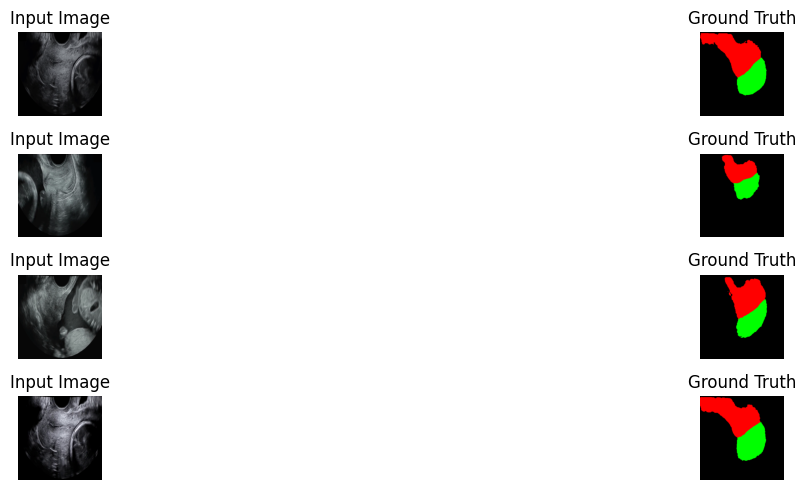

In [6]:
# Visualize unlabeled data with generated labels
visualize_predictions(
    image_dir="dataset/unlabeled_data/images",
    labels_dir="dataset/unlabeled_data/labels",
    num_samples=4
)